## Experiments with of a diffused censored GP in BayesNewton - Bike data

### Required imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "6" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [2]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import time
import objax
import jax.numpy as jnp
import math
from tqdm import tqdm
from censored_diffused_GP import *
import pandas as pd
from sklearn.metrics import r2_score
from bayesnewton.utils import (
    softplus,
    softplus_inv,
    sigmoid,
    sigmoid_diff,
)

np.random.seed(123)

LOG2PI = math.log(2 * math.pi)
INV2PI = (2 * math.pi) ** -1

### GP hyper-params

In [3]:
var_f = 1.0         # GP variance
len_time = 0.001     # GP lengthscale
len_space = 0.5
lik_variance = 1.  # Variance of the likelihood (in the case of Gaussian likelihood)
fix_lengthscale_time = True
fix_lengthscale_space = False
fix_lik_variance = False

sparse = False
opt_z = False  # will be set to False if sparse=False

### Load dataset

In [4]:
# Load data
import pickle
with open('datasets/Bike/data_dict_stations.pickle', 'rb') as f:
    dfs = pickle.load(f)

In [6]:
stations = [3711, 366, 496, 3641] 

dfs[stations[0]]

,hour_x,pick-ups,drop-offs,station,date,hour_y,temperature,dew_point_temperature,sunrise,precip_prob,humidity,wind_speed,icon_clear,icon_cloudy,icon_fog,icon_partly-cloudy,icon_rain,icon_sleet,icon_snow
datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,3711,1/1/2018,0,-11.100,-20.60,0,0.0,0.60,5.57,1,0,0,0,0,0,0
2018-01-01 01:00:00,1.0,0.0,1.0,3711,1/1/2018,1,-11.700,-20.60,0,0.0,0.61,5.17,1,0,0,0,0,0,0
2018-01-01 02:00:00,2.0,0.0,1.0,3711,1/1/2018,2,-12.200,-20.60,0,0.0,0.62,4.66,1,0,0,0,0,0,0
2018-01-01 03:00:00,3.0,0.0,0.0,3711,1/1/2018,3,-12.200,-20.00,0,0.0,0.62,4.38,1,0,0,0,0,0,0
2018-01-01 04:00:00,4.0,0.0,0.0,3711,1/1/2018,4,-12.800,-20.00,0,0.0,0.62,4.19,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,19.0,0.0,0.0,3711,12/31/2018,19,6.100,3.05,0,1.0,0.93,7.91,0,0,0,0,1,0,0
2018-12-31 20:00:00,20.0,1.0,1.0,3711,12/31/2018,20,6.100,3.30,0,1.0,0.95,8.59,0,0,0,0,1,0,0
2018-12-31 21:00:00,21.0,0.0,1.0,3711,12/31/2018,21,6.100,4.40,0,1.0,0.96,7.79,0,0,0,0,1,0,0


Time series length: 1465
3711 366 0.6955535099609943
3711 496 0.34690330631195954
3711 3641 0.3448979419862029
366 496 0.33843261953263243
366 3641 0.341328889882546
496 3641 0.8187835966864347


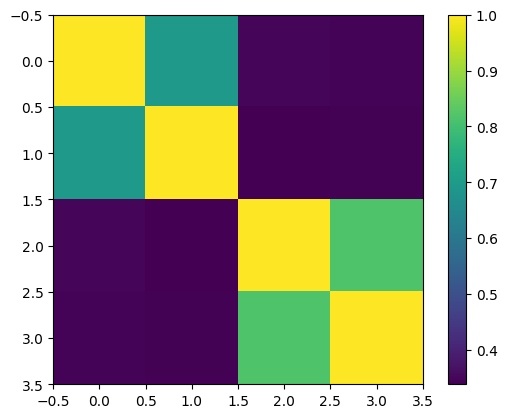

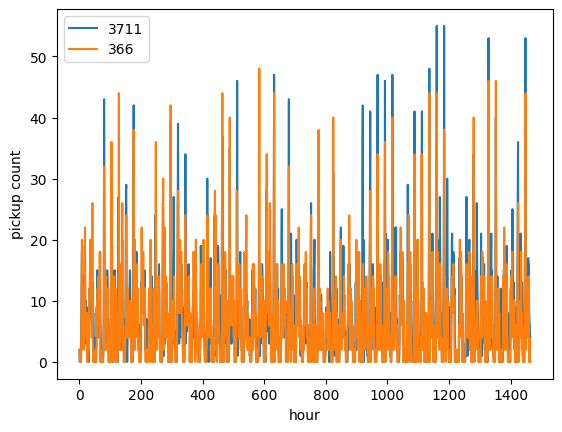

In [7]:
time_freq = '1h'
time_slice = pd.date_range(start='6/1/2018', end='8/1/2018', freq=time_freq)
print("Time series length:", len(time_slice))

weather = dfs[stations[0]]["precip_prob"][time_slice].values

pickups = {}
dropoffs = {}

for station in stations:
    pickups[station] = dfs[station]["pick-ups"][time_slice].values
    dropoffs[station] = dfs[station]["drop-offs"][time_slice].values

corrs = np.eye(len(stations))
for i in range(len(stations)):
    for j in range(i+1, len(stations)):
        corr = np.corrcoef(pickups[stations[i]], pickups[stations[j]])[0,1]
        corrs[i,j] = corr
        corrs[j,i] = corr
        print(stations[i], stations[j], corr)
plt.imshow(corrs)
plt.colorbar()
plt.show()

plt.plot(pickups[stations[0]][:])
plt.plot(pickups[stations[1]][:])
plt.xlabel("hour")
plt.ylabel("pickup count")
plt.legend([str(stations[0]), str(stations[1])])
plt.show()

### Censor time-series

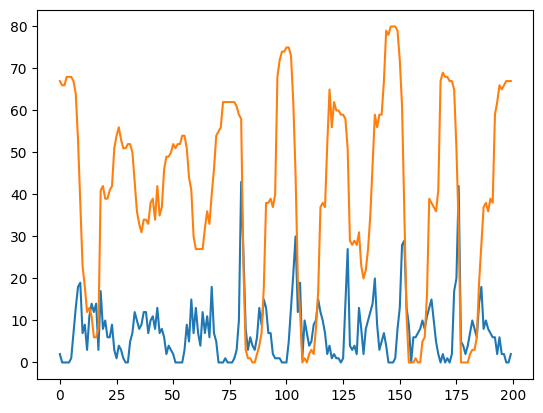

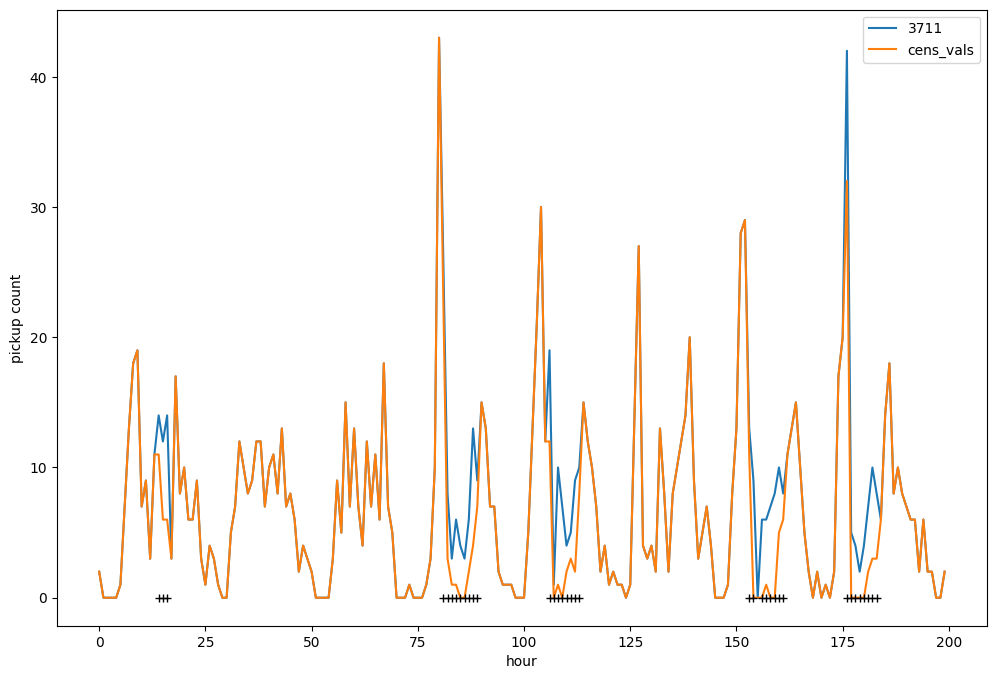

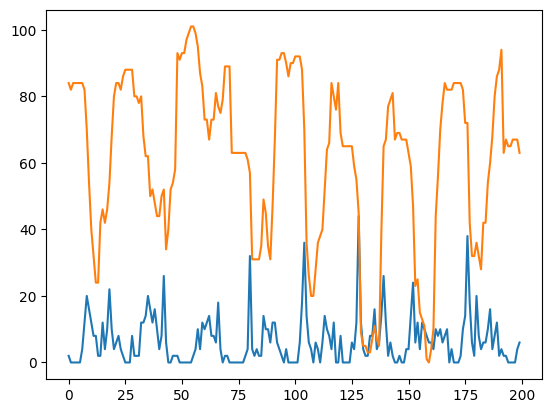

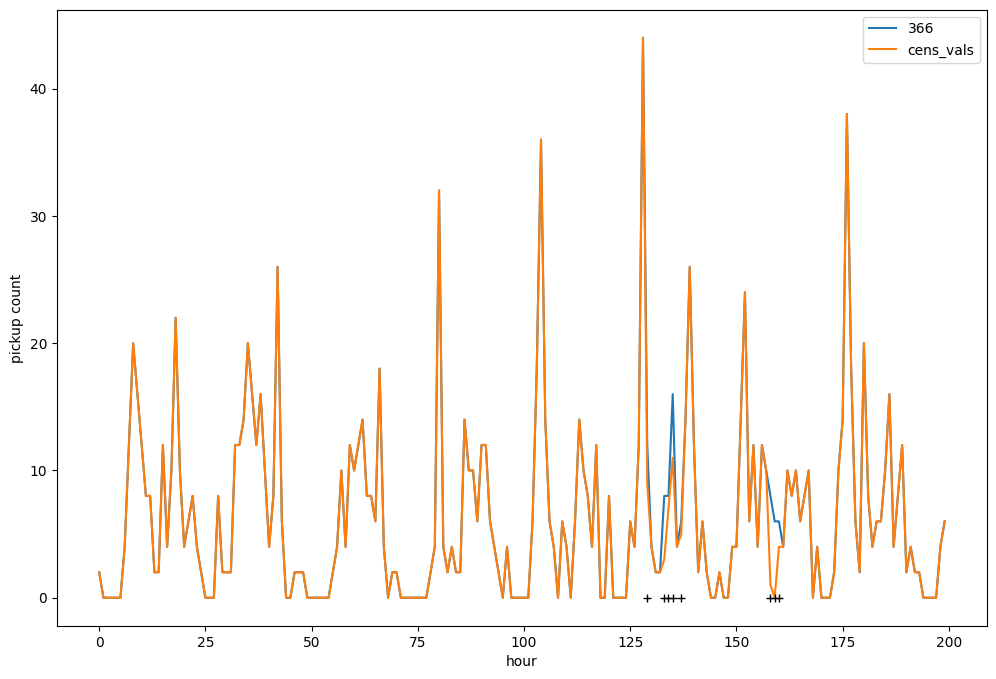

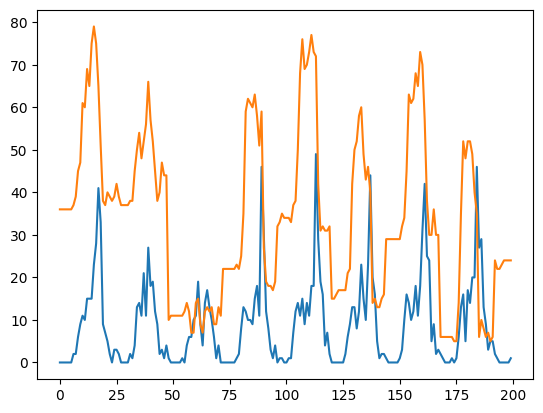

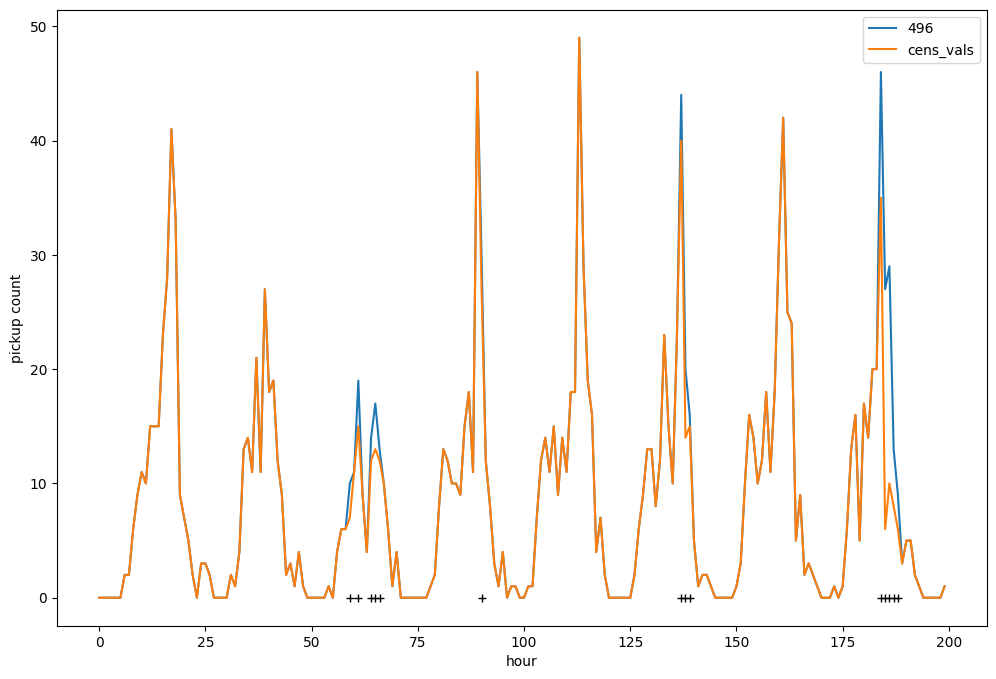

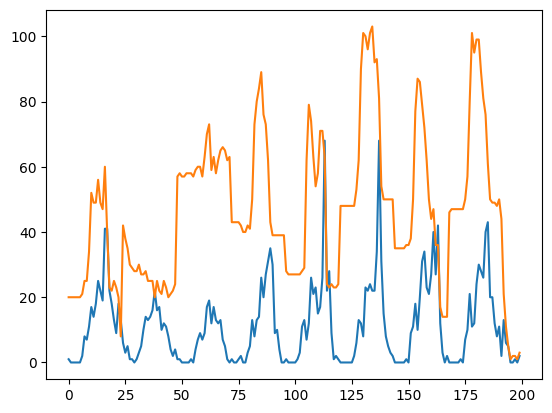

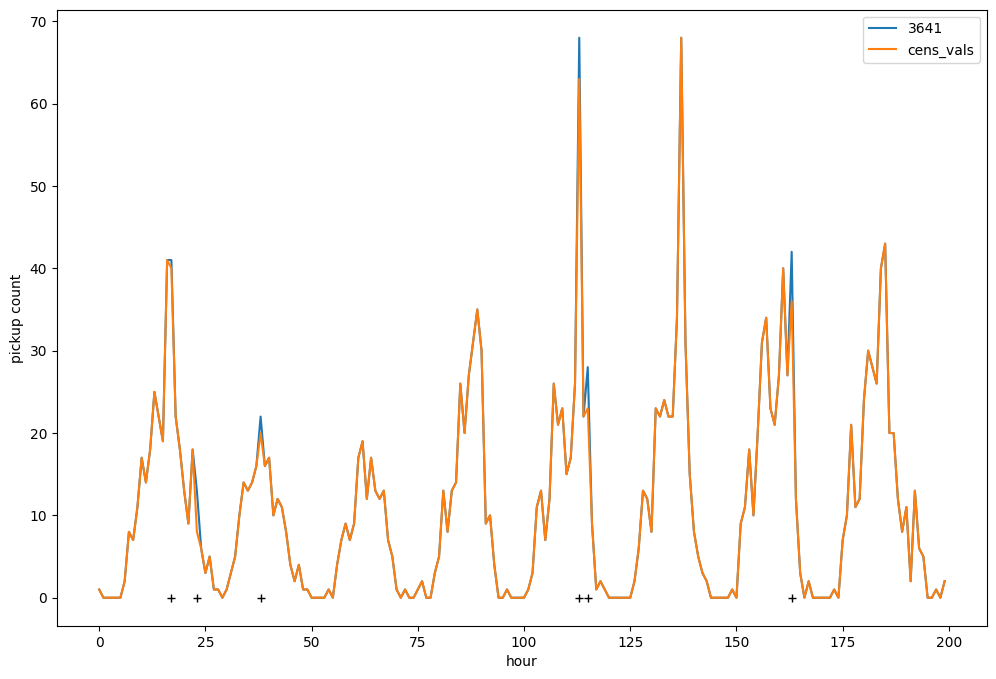

In [8]:
from datetime import timedelta

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x)) 

np.set_printoptions(precision=2, suppress=True)

def censor_st_data(st, supply_guess_func):
    window_size = 1
    balance_stats = []
    est_supply = []
    for t in range(len(time_slice)):
        balance_stat = dfs[st]["drop-offs"][time_slice[t]-timedelta(hours=1)] - dfs[st]["pick-ups"][time_slice[t]-timedelta(hours=1)]
        balance_stats.append(balance_stat)
        if t % 24 == 0:
            #supply_guess = np.random.rand()*40+40 # start of the day repositioning of supply
            supply_guess = supply_guess_func()
        else:
            supply_guess = max(0, est_supply[-1] + dfs[st]["drop-offs"][time_slice[t]-timedelta(hours=1)] - dfs[st]["pick-ups"][time_slice[t]-timedelta(hours=1)])
        est_supply.append(supply_guess)
    
    balance_stats = np.array(balance_stats)
    est_supply = np.array(est_supply).astype(int)
    
    plot_window_size = 200
    plt.plot(pickups[st][:plot_window_size])
    plt.plot(est_supply[:plot_window_size])
    plt.show()
    
    censoring_locs = (pickups[st] > est_supply).astype(int)
    censored_vals = np.minimum(pickups[st], est_supply)
    
    plt.figure(figsize=(12,8))
    plt.plot(pickups[st][:200])
    plt.plot(censored_vals[:200])
    plt.plot(np.where(censoring_locs[:200]), np.zeros(len(np.where(censoring_locs[:200]))), 'k+')
    plt.xlabel("hour")
    plt.ylabel("pickup count")
    plt.legend([str(st), "cens_vals"])
    plt.show()
    
    return censored_vals, censoring_locs, est_supply

# censor station 1 (3711)
censored_vals, censoring_locs, est_supply = censor_st_data(stations[0], lambda: np.random.rand()*40+40)

# censor station 2 (366)
censored_vals2, censoring_locs2, est_supply2 = censor_st_data(stations[1], lambda: np.random.rand()*40+60)

# censor station 3 (229)
censored_vals3, censoring_locs3, est_supply3 = censor_st_data(stations[2], lambda: np.random.rand()*40+0)

# censor station 4 (435)
censored_vals4, censoring_locs4, est_supply4 = censor_st_data(stations[3], lambda: np.random.rand()*40+20)

In [9]:
np.sum(censoring_locs) / len(censoring_locs), np.sum(censoring_locs2) / len(censoring_locs2), np.sum(censoring_locs3) / len(censoring_locs3), np.sum(censoring_locs4) / len(censoring_locs4)

(0.2054607508532423,
 0.034129692832764506,
 0.09078498293515358,
 0.019795221843003412)

### Place stations at random in 2-D space 

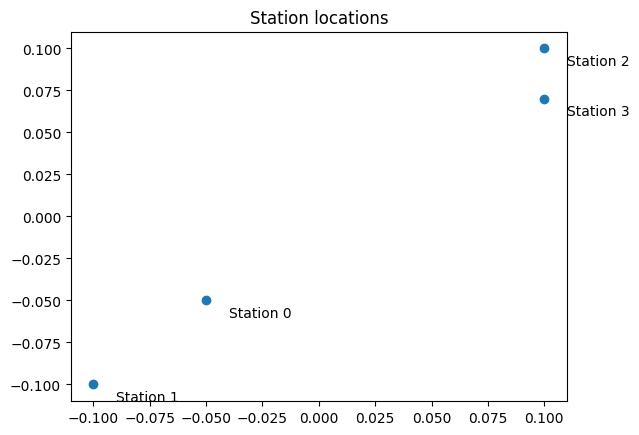

In [10]:
num_stations = 4 
# stations are the following [3711, 366, 229, 435]
station_locations = np.array([[-0.05,-0.05], [-0.1,-0.1], [0.1,0.1], [0.1,0.07]])
station_locations

plt.scatter(station_locations[:,0], station_locations[:,1])
for i in range(num_stations):
    plt.annotate("Station %d" % (i,), station_locations[i]+np.array([0.01,-0.01]))
plt.title("Station locations")
plt.show()

Station 3711: fraction of censored observations = 0.21


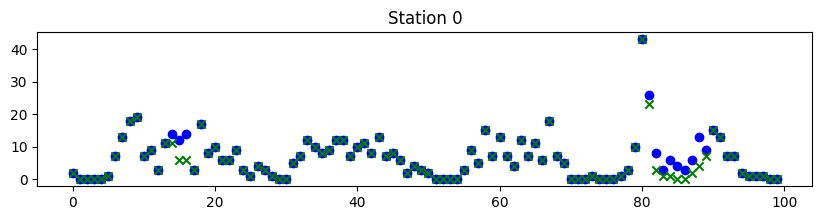

Station 366: fraction of censored observations = 0.03


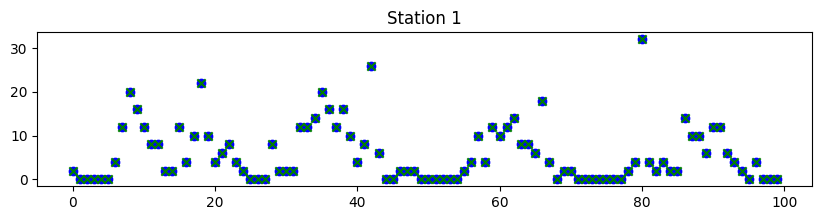

Station 496: fraction of censored observations = 0.09


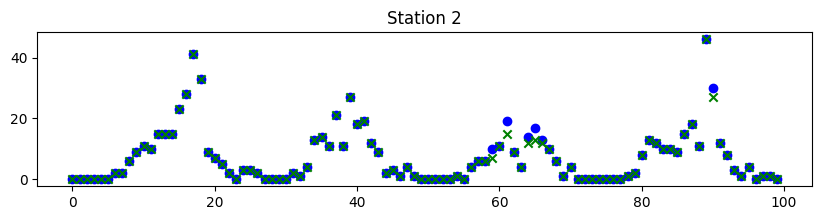

Station 3641: fraction of censored observations = 0.02


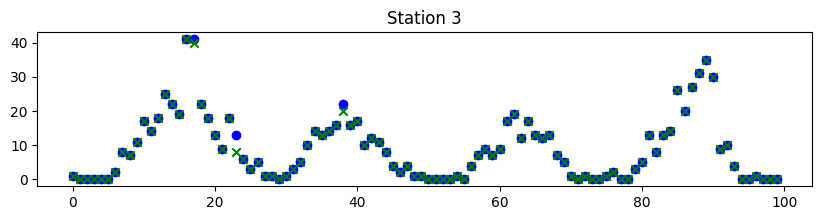

(torch.Size([4, 1465]), torch.Size([4, 1465]))

In [11]:
import torch
num_stations = 4
x = torch.arange(len(pickups[stations[0]]))
true_demands = [torch.tensor(pickups[stations[0]]).unsqueeze(0), 
                torch.tensor(pickups[stations[1]]).unsqueeze(0), 
                torch.tensor(pickups[stations[2]]).unsqueeze(0), 
                torch.tensor(pickups[stations[3]]).unsqueeze(0)]
censored_demands = [torch.tensor(censored_vals).unsqueeze(0), 
                    torch.tensor(censored_vals2).unsqueeze(0), 
                    torch.tensor(censored_vals3).unsqueeze(0), 
                    torch.tensor(censored_vals4).unsqueeze(0)]

plot_window_size = 100
for i in range(num_stations):
    true_demand = true_demands[i]
    censored_demand = censored_demands[i]
    
    print("Station %s: fraction of censored observations = %.2f" % (stations[i], torch.sum(true_demand != censored_demand)/len(true_demand[0])))
    
    plt.figure(figsize=(10,2))
    plt.scatter(x[:plot_window_size], true_demand[0,:plot_window_size], marker='o', c='blue')
    plt.scatter(x[:plot_window_size], censored_demand[0,:plot_window_size], marker='x', c='green')
    plt.title('Station %d' % (i,))
    plt.show()
    
true_demands = torch.concatenate(true_demands, dim=0)
censored_demands = torch.concatenate(censored_demands, dim=0)
true_demands.shape, censored_demands.shape

### Compute similarity matrix between stations based on RBF kernel

In [12]:
print("----------------------- My diffusion kernel:")
#transition_matrix = compute_transition_matrix(X_diffusion, diffusion_lengthscale=0.1, sink_prob=0.01)
transition_matrix = compute_transition_matrix(station_locations, diffusion_lengthscale=0.03, sink_prob=0.0)
transition_matrix = torch.tensor(transition_matrix.tolist())[:num_stations,:num_stations].double()
print(transition_matrix)

----------------------- My diffusion kernel:
tensor([[0.0000e+00, 1.0000e+00, 2.2336e-10, 2.0107e-08],
        [1.0000e+00, 0.0000e+00, 8.0241e-19, 3.8242e-16],
        [2.2897e-11, 8.2257e-20, 0.0000e+00, 1.0000e+00],
        [2.0612e-09, 3.9203e-17, 1.0000e+00, 0.0000e+00]], dtype=torch.float64)


### Compute transition matrix for diffusion process based on station similarity matrix above

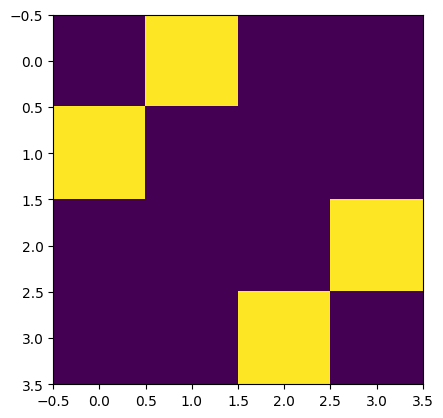

station 0->1 with prob=100.0%
station 1->0 with prob=100.0%
station 2->3 with prob=100.0%
station 3->2 with prob=100.0%


In [13]:
plt.imshow(transition_matrix)
plt.show()

for i in range(num_stations):
    for j in range(num_stations):
        if transition_matrix[i,j]>0.1:
            print("station %d->%d with prob=%.1f%%" % (i,j,100*transition_matrix[i,j]))

### Diffuse excess demand based on transition matrix define above for k diffusion steps

In [14]:
diffusion_steps = 1
diffused_demands = censored_demands.clone().detach()
for step in range(diffusion_steps):
    for t in range(censored_demands.shape[1]):
        excess_demand = true_demands[:,t] - diffused_demands[:,t]
        #diffused_demands[:,t] = diffused_demands[:,t] + np.dot(transition_matrix, excess_demand)
        diffused_demands[:,t] = diffused_demands[:,t] + torch.mm(excess_demand.unsqueeze(0), transition_matrix)
    
diffused_demands.shape

torch.Size([4, 1465])

In [15]:
# get supply
supply = torch.tensor(np.concatenate([est_supply[None,:], est_supply2[None,:], est_supply3[None,:], est_supply4[None,:]]))
print(supply.shape)

# throw away excess demand even after diffusion
diffused_demands = torch.minimum(diffused_demands, supply)

torch.Size([4, 1465])


### Plot observed demand data after diffusion process over the excess demand

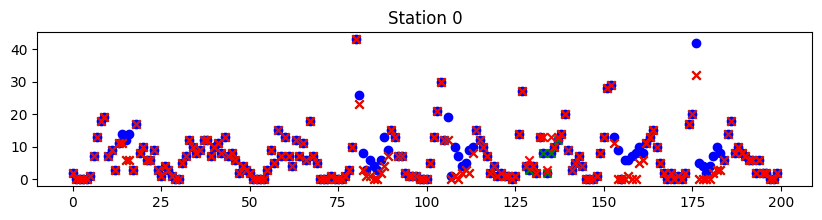

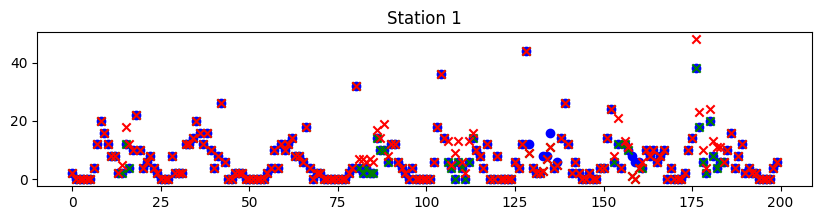

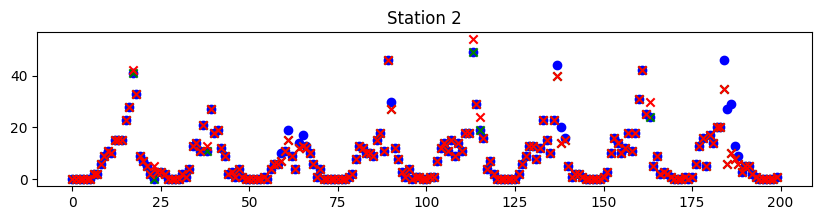

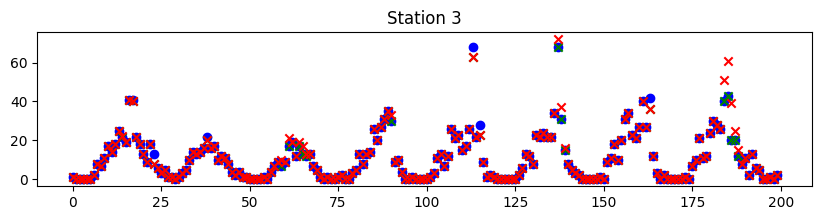

In [16]:
plot_window_size = 200
for i in range(num_stations):
    plt.figure(figsize=(10,2))
    plt.scatter(x[:plot_window_size], true_demands[i,:plot_window_size], marker='o', c='blue')
    #plt.plot(x, stations_demand_cap[i]*np.ones(len(x)), c='red')
    plt.scatter(x[:plot_window_size], censored_demands[i,:plot_window_size], marker='x', c='green')
    plt.scatter(x[:plot_window_size], diffused_demands[i,:plot_window_size].detach().cpu(), marker='x', c='red')
    plt.title('Station %d' % (i,))
    plt.show()

In [17]:
train_perc = 0.7    # Percentage of data used for training
N_test = int((1-train_perc)*true_demands.shape[1])
print("N_test:", N_test)
perm = np.random.permutation(true_demands.shape[1])
ix_train = sorted(perm[:-N_test].copy())
ix_test = sorted(perm[-N_test:].copy())

x_all = np.linspace(0,1,true_demands.shape[1])

N = true_demands.shape[1] - N_test
print("N:", N)
x = x_all[ix_train]
print("\nx:", x.shape)
y = true_demands.T.numpy()[ix_train,:,None]
print("y:", y.shape)
y_cens = censored_demands.T.numpy()[ix_train,:,None]
print("y_cens:", y_cens.shape)
y_diffused = diffused_demands.T.detach().numpy()[ix_train,:,None]
print("y_diffused:", y_diffused.shape)
censoring_thre = np.concatenate([est_supply[:,None], 
                                 est_supply2[:,None], 
                                 est_supply3[:,None], 
                                 est_supply4[:,None]], axis=1)[ix_train,:,None]
print("censoring_thre:", censoring_thre.shape)
censoring_indicator = y > censoring_thre
print("censoring_indicator:", censoring_indicator.shape)

x_test = x_all[ix_test]
print("\nx_test:", x_test.shape)
y_test = true_demands.T.numpy()[ix_test,:,None]
print("y_test:", y_test.shape)
y_cens_test = censored_demands.T.numpy()[ix_test,:,None]
print("y_cens_test:", y_cens_test.shape)
y_diffused_test = diffused_demands.T.detach().numpy()[ix_test,:,None]
print("y_diffused_test:", y_diffused_test.shape)
censoring_thre_test = np.concatenate([est_supply[:,None], 
                                      est_supply2[:,None], 
                                      est_supply3[:,None], 
                                      est_supply4[:,None]], axis=1)[ix_test,:,None]
print("censoring_thre_test:", censoring_thre_test.shape)
censoring_indicator_test = y_test > censoring_thre_test
print("censoring_indicator_test:", censoring_indicator_test.shape)

N_test: 439
N: 1026

x: (1026,)
y: (1026, 4, 1)
y_cens: (1026, 4, 1)
y_diffused: (1026, 4, 1)
censoring_thre: (1026, 4, 1)
censoring_indicator: (1026, 4, 1)

x_test: (439,)
y_test: (439, 4, 1)
y_cens_test: (439, 4, 1)
y_diffused_test: (439, 4, 1)
censoring_thre_test: (439, 4, 1)
censoring_indicator_test: (439, 4, 1)


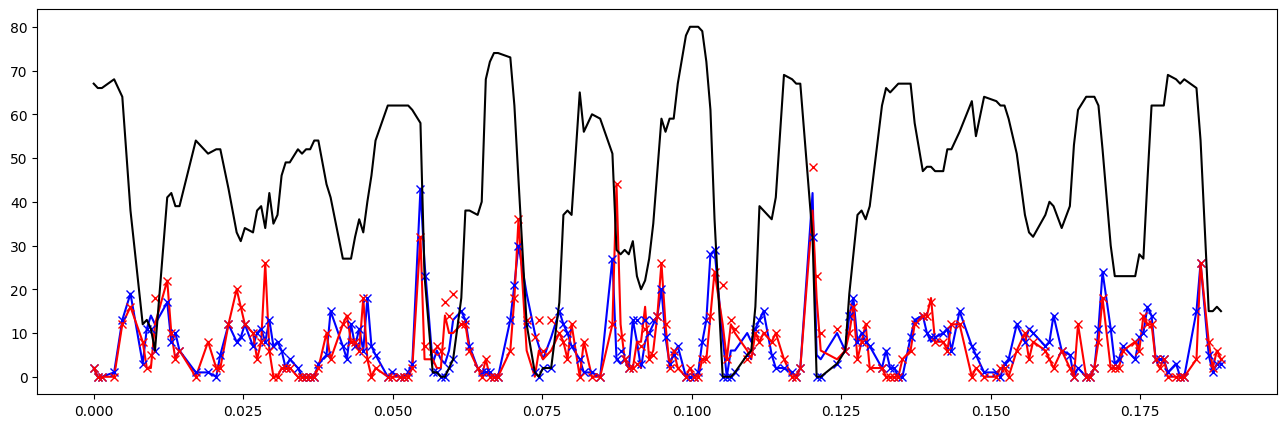

In [18]:
plt.figure(1, figsize=(16, 5))
window_size = 200
#plt.plot(x, f1, 'b-')
#plt.plot(x, f2, 'r-')
plt.plot(x[:window_size], y[:window_size, 0], 'b-')
plt.plot(x[:window_size], y[:window_size, 1], 'r-')
#plt.plot(x, y_cens[:, 0], 'bx')
#plt.plot(x, y_cens[:, 1], 'rx')
plt.plot(x[:window_size], y_diffused[:window_size, 0], 'bx')
plt.plot(x[:window_size], y_diffused[:window_size, 1], 'rx')
plt.plot(x[:window_size], censoring_thre[:window_size,0], 'k-')
plt.show()

In [19]:
X_diffusion = jnp.array(station_locations)

R = np.repeat(X_diffusion[None,:], len(x),axis=0)
print("R.shape:", R.shape)

R_test = np.repeat(X_diffusion[None,:], len(x_test),axis=0)
print("R_test.shape:", R_test.shape)

if sparse:
    z1 = np.linspace(np.min(X_diffusion[:, 0]), np.max(X_diffusion[:, 0]), num=7)
    z2 = np.linspace(np.min(X_diffusion[:, 1]), np.max(X_diffusion[:, 1]), num=7)
    zA, zB = np.meshgrid(z1, z2)  # Adding additional dimension to inducing points grid
    z = np.hstack((zA.reshape(-1, 1), zB.reshape(-1, 1)))  # Flattening grid for use in kernel functions
    del z1, z2, zA, zB
else:
    z = R[0, ...]
    
#z = R[0, ...]
    
print("z.shape:", z.shape)

print("----------------------- Regularized Laplacian kernel:")
print(k_RL(X_diffusion, lengthscale=10, beta=1))

print("----------------------- Diffusion kernel:")
print(k_Diff(X_diffusion, lengthscale=10, beta=1))

print("----------------------- My diffusion kernel:")
print(compute_transition_matrix(X_diffusion, diffusion_lengthscale=10))

R.shape: (1026, 4, 2)
R_test.shape: (439, 4, 2)
z.shape: (4, 2)
----------------------- Regularized Laplacian kernel:
W: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Lap: [[ 3. -1. -1. -1.]
 [-1.  3. -1. -1.]
 [-1. -1.  3. -1.]
 [-1. -1. -1.  3.]]
[[0.4 0.2 0.2 0.2]
 [0.2 0.4 0.2 0.2]
 [0.2 0.2 0.4 0.2]
 [0.2 0.2 0.2 0.4]]
----------------------- Diffusion kernel:
W: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Lap: [[ 3. -1. -1. -1.]
 [-1.  3. -1. -1.]
 [-1. -1.  3. -1.]
 [-1. -1. -1.  3.]]
[[0.05 2.72 2.72 2.72]
 [2.72 0.05 2.72 2.72]
 [2.72 2.72 0.05 2.72]
 [2.72 2.72 2.72 0.05]]
----------------------- My diffusion kernel:
[[0.   0.33 0.33 0.33]
 [0.33 0.   0.33 0.33]
 [0.33 0.33 0.   0.33]
 [0.33 0.33 0.33 0.  ]]


censoring_threshold: (1026, 4) 
 [[67 84 36 20]
 [66 82 36 20]
 [66 84 36 20]
 [68 84 36 20]
 [64 82 39 25]]
f: (1026, 4) 
 [[ 2.  2.  0.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [13. 12.  2.  8.]]
excess_demand: (1026, 4) 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
diffused_f: (1026, 4) 
 [[ 2.  2.  0.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [13. 12.  2.  8.]]


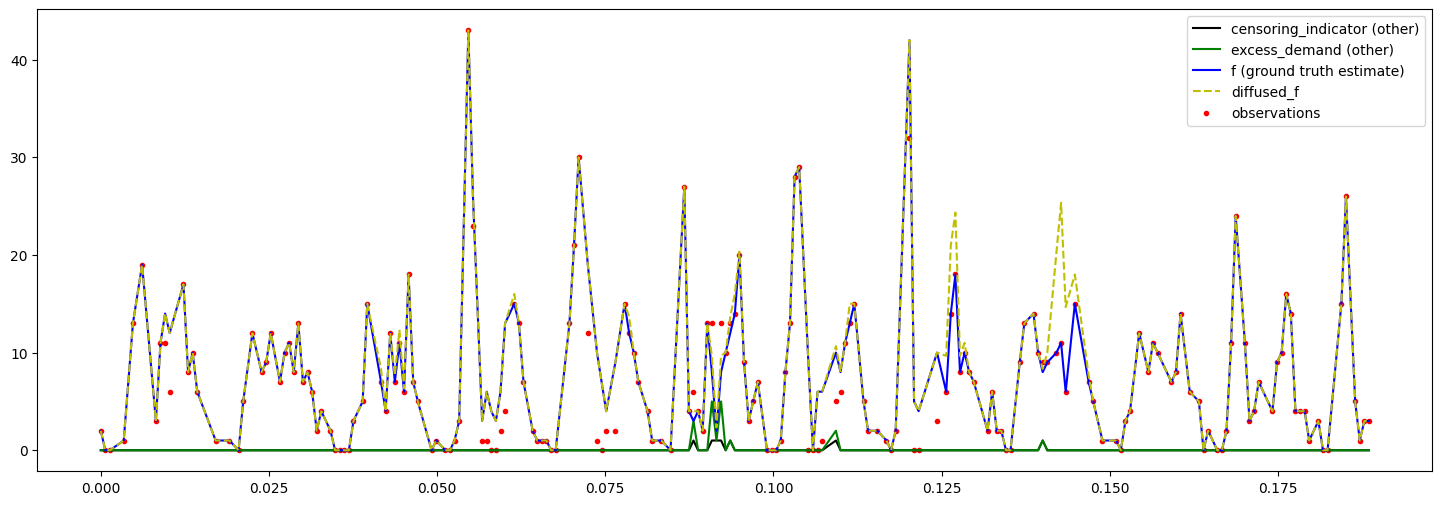

In [20]:
### Testing out the diffusion process to see if it is working
transition_matrix = compute_transition_matrix(X_diffusion, diffusion_lengthscale=10)

### Diffuse excess demand based on transition matrix define above for k diffusion steps
censoring_threshold = censoring_thre[:,:,0]
print("censoring_threshold:", censoring_threshold.shape, '\n', censoring_threshold[:5])
f = y[:,:,0] ## assume perfect estimate for f
print("f:", f.shape, '\n', f[:5])
excess_demand = jnp.maximum(f - censoring_threshold, jnp.zeros(f.shape))
print("excess_demand:", excess_demand.shape, '\n', excess_demand[:5])
diffused_f = f + excess_demand @ transition_matrix
print("diffused_f:", diffused_f.shape, '\n', diffused_f[:5])
plt.figure(figsize=(18,6))
window_size = 200
plt.plot(x[:window_size], censoring_indicator[:window_size,1], 'k-')
plt.plot(x[:window_size], excess_demand[:window_size,1], 'g-')
plt.plot(x[:window_size], f[:window_size,0], 'b-')
plt.plot(x[:window_size], diffused_f[:window_size,0], 'y--')
plt.scatter(x[:window_size], y_diffused[:window_size,0,0], marker='.', c='r')
plt.legend(["censoring_indicator (other)", 
            "excess_demand (other)", 
            "f (ground truth estimate)", 
            "diffused_f",
            "observations"])
plt.show()

### Re-usable code blocks for training and evaluating models

In [21]:
def train_model(model, iters=500, lr_adam = 0.1, lr_newton = 1.):
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())

    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E

    train_op = objax.Jit(train_op)

    t0 = time.time()
    loop = tqdm(range(iters))
    losses = []
    for i in loop:
        loss = train_op()
        #if not i % 20:
        #    print('iter %2d, energy: %1.4f' % (i, loss[0]))
        loop.set_description(f"Iter [{i}/{iters}]")
        loop.set_postfix(loss=loss[0])
        losses.append(loss[0])
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    plt.figure(1, figsize=(6, 4))
    plt.plot(losses, label='training loss')
    plt.title("Training loss")
    plt.show()
    
    return model
    

def eval_model(model, x, R, extra, y, y_diffused, x_test, R_test, extra_test, y_test):
    t0 = time.time()
    # evaluate on train set 
    posterior_mean_train, posterior_cov_train = model.predict_y(X=x, R=R)
    nlpd_train_diff = model.negative_log_predictive_density(X=x, R=R, extra=extra, Y=y_diffused)
    nlpd_train = model.negative_log_predictive_density(X=x, R=R, extra=extra, Y=y)
    rmse_train = np.sqrt(np.mean((y[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    r2_train = r2_score(y[:,:posterior_mean_train.shape[1],0], np.array(posterior_mean_train)) 
    print('[trainset] nlpd (diffused): %2.3f\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f' % (nlpd_train_diff, nlpd_train, rmse_train, r2_train))

    # evaluate on test set 
    posterior_mean_test, posterior_cov_test = model.predict_y(X=x_test, R=R_test)
    nlpd_test = model.negative_log_predictive_density(X=x_test, R=R_test, extra=extra_test, Y=y_test)
    rmse_test = np.sqrt(np.mean((y_test[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    r2_test = r2_score(y_test[:,:posterior_mean_test.shape[1],0], np.array(posterior_mean_test))
    print('[testset] \t\t\t\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f' % (nlpd_test, rmse_test, r2_test))
    t1 = time.time()
    print('prediction time: %2.2f secs' % (t1-t0))

    # make plots with predictions
    posterior_mean, posterior_var = model.predict_y(X=x, R=R)
    lb = posterior_mean - 1.96 * posterior_var ** 0.5
    ub = posterior_mean + 1.96 * posterior_var ** 0.5

    print('plotting ...')
    plt.figure(1, figsize=(12, 4))
    plt.clf()
    window_size = 200
    plt.plot(x[:window_size], y_diffused[:window_size, 0], 'bx', label="y_diffused")
    plt.plot(x[:window_size], y_diffused[:window_size, 1], 'rx')
    # plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
    plt.plot(x[:window_size], posterior_mean[:window_size, 0], 'b')
    plt.plot(x[:window_size], posterior_mean[:window_size, 1], 'r')
    plt.plot(x[:window_size], y[:window_size,0], 'b--')
    plt.plot(x[:window_size], y[:window_size,1], 'r--')
    plt.fill_between(x[:window_size], lb[:window_size, 0], ub[:window_size, 0], color='b', alpha=0.05)
    plt.fill_between(x[:window_size], lb[:window_size, 1], ub[:window_size, 1], color='r', alpha=0.05)
    plt.xlim([x[0], x[window_size]])
    if hasattr(model, 'Z'):
        plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
    plt.legend()
    plt.title('Multivariate GP regression')
    plt.xlabel('$X$')
    plt.show()

# Fits on true data

### Fit Gaussian GP to true data

In [21]:
# for key, param in model.vars().items():
#     if "kernel" in key:
#         print(key.replace("(MarkovVariationalGP).kernel(SpatioTemporalKernel).", ""), softplus(param.value))

Iter [999/1000]: 100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s, loss=13786.788752494507]

optimisation time: 257.73 secs


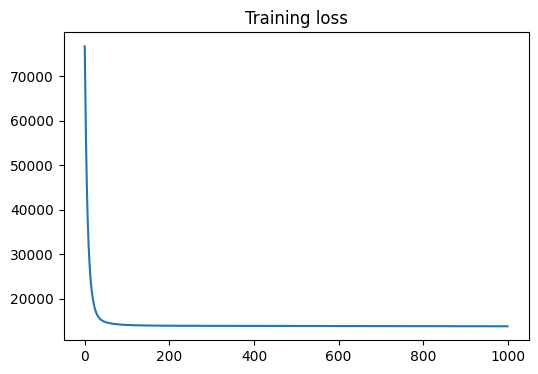

In [22]:
# model definition
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time, fix_lengthscale=fix_lengthscale_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=1., period=7*24/len(time_slice), order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyGaussian(variance=lik_variance, fix_variance=fix_lik_variance)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, R=R, Y=y)

model = train_model(model, iters=1000, lr_adam = 0.1, lr_newton = 1.)

[trainset] nlpd (diffused): 2.717	nlpd (true): 2.091	rmse (true): 1.220	r2 (true): 0.984
[testset] 				nlpd (true): 3.208	rmse (true): 6.048	r2 (true): 0.436
prediction time: 9.10 secs
plotting ...


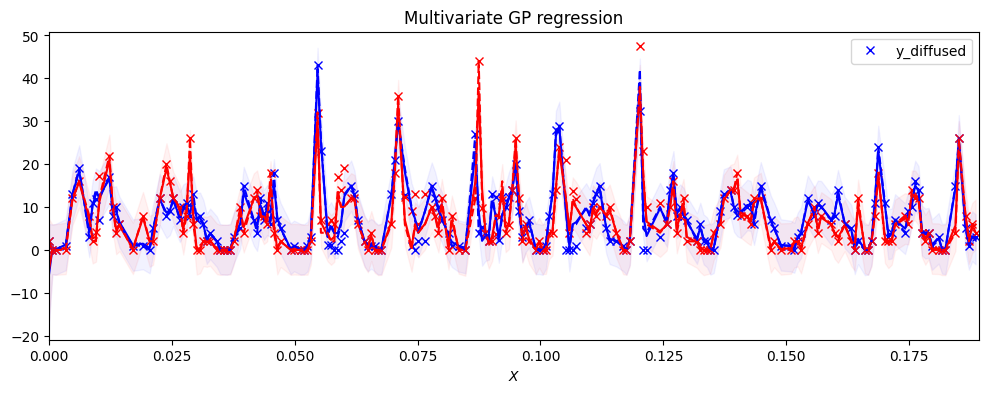

In [23]:
eval_model(model, x, R, None, y, y_diffused, x_test, R_test, None, y_test)

# Fits on diffused data

### Fit Gaussian GP to diffused data

Iter [999/1000]: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s, loss=14049.78537177685]

optimisation time: 266.48 secs


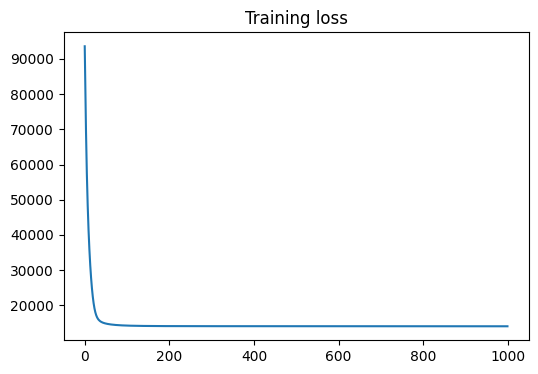

In [24]:
# model definition
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time, fix_lengthscale=fix_lengthscale_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=1., period=7*24/len(time_slice), order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyGaussian(variance=lik_variance, fix_variance=fix_lik_variance)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, R=R, Y=y_diffused)

model = train_model(model, iters=1000, lr_adam = 0.1, lr_newton = 1.)

[trainset] nlpd (diffused): 1.877	nlpd (true): 2.674	rmse (true): 4.016	r2 (true): 0.805
[testset] 				nlpd (true): 3.297	rmse (true): 6.603	r2 (true): 0.332
prediction time: 6.91 secs
plotting ...


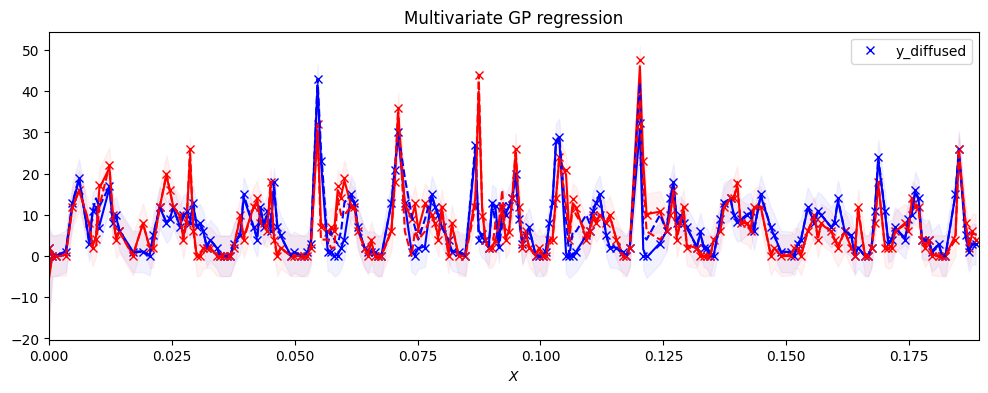

In [25]:
eval_model(model, x, R, None, y, y_diffused, x_test, R_test, None, y_test)

# Censored models

### Fit Censored Gaussian GP to diffused data

Iter [999/1000]: 100%|██████████| 1000/1000 [04:36<00:00,  3.61it/s, loss=12458.393149014206]

optimisation time: 276.92 secs


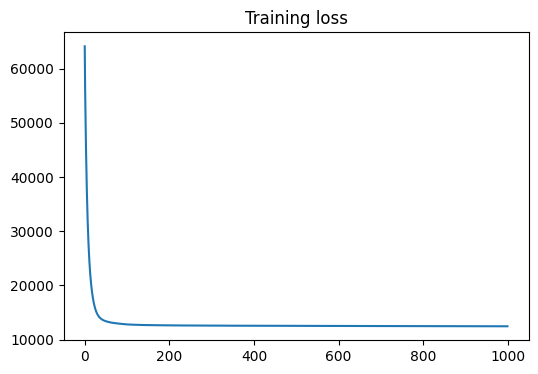

In [26]:
# model definition
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time, fix_lengthscale=fix_lengthscale_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=1., period=7*24/len(time_slice), order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyCensoredGaussian(variance=lik_variance, fix_variance=fix_lik_variance)
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=np.concatenate([y_diffused, censoring_thre], axis=2))
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, R=R, Y=y_diffused, extra=jnp.array(censoring_thre))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, R=R, Y=y_diffused, extra=1+jnp.array(y_diffused))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters=1000, lr_adam = 0.1, lr_newton = 1.)

[trainset] nlpd (diffused): 1.937	nlpd (true): 2.552	rmse (true): 4.197	r2 (true): 0.769
[testset] 				nlpd (true): 3.252	rmse (true): 6.436	r2 (true): 0.365
prediction time: 8.04 secs
plotting ...


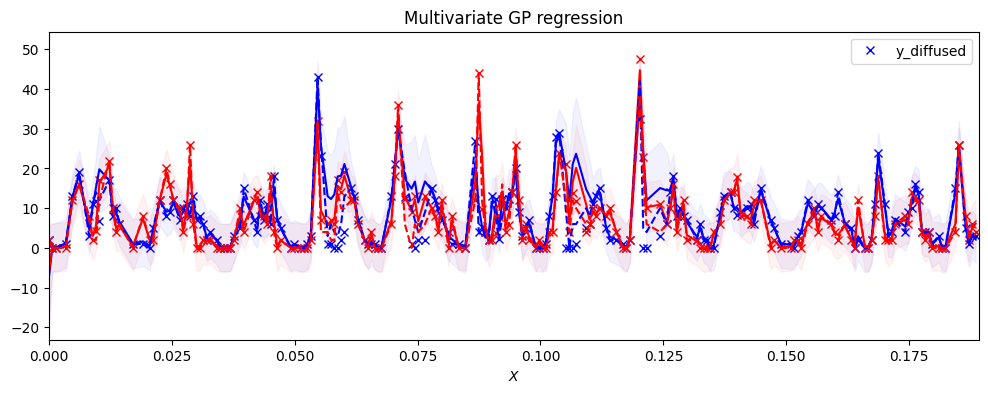

In [27]:
eval_model(model, x, R, jnp.array(censoring_thre), y, y_diffused, x_test, R_test, jnp.array(censoring_thre_test), y_test)

# Diffused models

### Diffused Censored Gaussian GP to diffused data - D

Iter [999/1000]: 100%|██████████| 1000/1000 [07:54<00:00,  2.11it/s, loss=12327.499741883614]


optimisation time: 474.70 secs


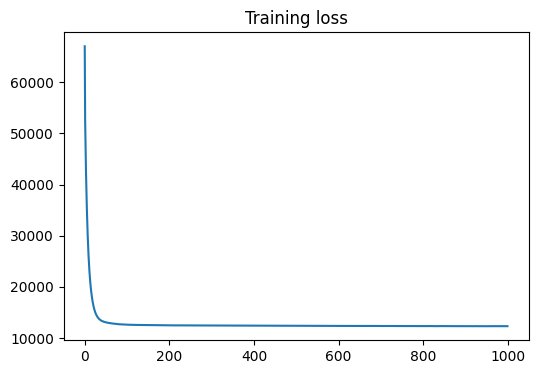

In [34]:
# model definition
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time, fix_lengthscale=fix_lengthscale_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=1., period=7*24/len(time_slice), order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space, fix_lengthscale=fix_lengthscale_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyDiffusedCensoredGaussianD(X_diffusion=X_diffusion, 
                                diffusion_steps=1,
                                diffusion_lengthscale=0.03,
                                diffusion_variance=1.,
                                fix_diffusion=False,
                                variance=lik_variance, 
                                fix_variance=fix_lik_variance)
#lik = MyGaussian(variance=lik_variance)
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=np.concatenate([y_diffused, censoring_thre], axis=2))
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, R=R, Y=y_diffused, extra=jnp.array(censoring_thre))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters=1000, lr_adam = 0.1, lr_newton = 1.)
#model = train_model(model, iters=3000, lr_newton=0.1, lr_adam=0.01)
#model = train_model(model, iters=500)

[trainset] nlpd (diffused): 2.224	nlpd (true): 2.328	rmse (true): 2.983	r2 (true): 0.885
[testset] 				nlpd (true): 3.171	rmse (true): 5.977	r2 (true): 0.448
prediction time: 10.10 secs
plotting ...


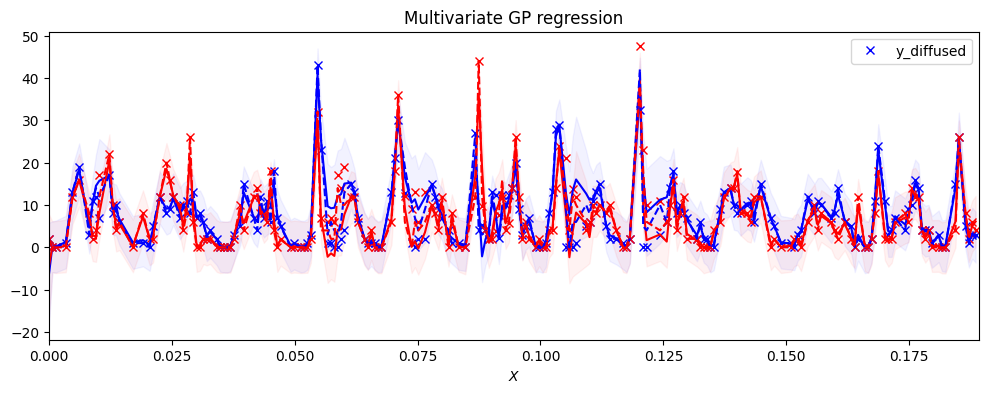

In [33]:
eval_model(model, x, R, jnp.array(censoring_thre), y, y_diffused, x_test, R_test, jnp.array(censoring_thre_test), y_test)

[trainset] nlpd (diffused): 2.124	nlpd (true): 2.311	rmse (true): 2.992	r2 (true): 0.882
[testset] 				nlpd (true): 3.175	rmse (true): 5.982	r2 (true): 0.449
prediction time: 8.96 secs
plotting ...


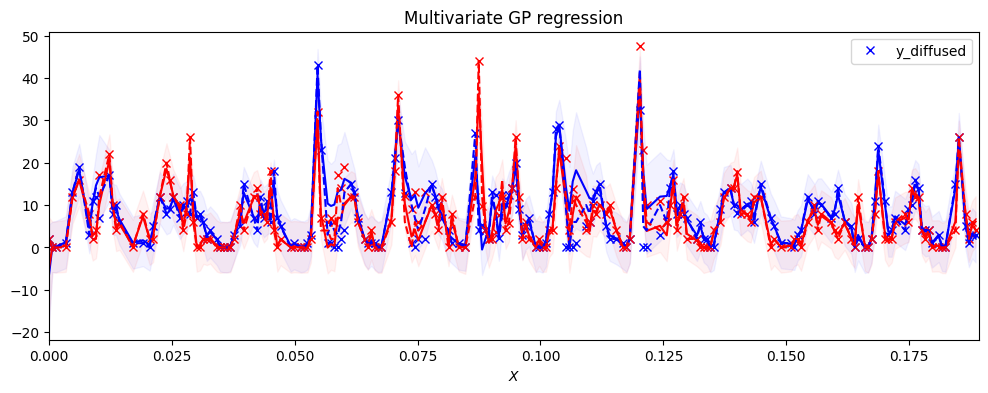

In [35]:
eval_model(model, x, R, jnp.array(censoring_thre), y, y_diffused, x_test, R_test, jnp.array(censoring_thre_test), y_test)